In [3808]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3809]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3810]:
from datasets.carla import *
from datasets.nuscenes import *

from pyquaternion import Quaternion
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import (box_in_image,
                                           view_points, BoxVisibility)

from models.baseline import *
from tools.utils import *
from tools.geometry import *

from time import time
from tqdm import tqdm
import random

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)

In [3811]:
carla_data = CarlaDataset("../../data/carla/val", False)

In [3812]:
nusc, dataroot = get_nusc("mini", "../../data/nuscenes")
ns_data = NuScenesDataset(nusc, False)

In [3813]:
bev_resolution, bev_start_position, bev_dimension = calculate_birds_eye_view_parameters(
    [-50.0, 50.0, 0.5], [-50.0, 50.0, 0.5], [-10.0, 10.0, 20.0]
)

bev_resolution, bev_start_position, bev_dimension = bev_resolution.numpy(), bev_start_position.numpy(), bev_dimension.numpy()

In [3876]:
images, intrinsics, extrinsics, labels = carla_data[127]
size = [2.25, 5., 2.] # w h d
trans = [-8, 4.25, size[2] / 2]
rot = euler_to_quaternion(0, 0, 0)

cam = 2
type = 'carla'

In [3931]:
images, intrinsics, extrinsics, labels = ns_data[64]
size = [2.5, 5., 2.] # w h d
trans = [-2, -15, size[2] / 2]

rot = euler_to_quaternion(0, 0, 60)

cam = 3
type = 'nuscenes'

Isolate intrinsics + extrinsics, uninverse extrinsics

In [3932]:
intrinsic = intrinsics[cam]
# extrinsic = np.array(extrinsics[cam])
extrinsic = np.linalg.inv(extrinsics[cam])

In [3933]:
from scipy.spatial.transform import Rotation   

r = Rotation.from_matrix(extrinsic[:3, :3])
r.as_euler("zyx", degrees=True)

array([161.42034391,  -0.1416276 ,  88.81655298])

In [3934]:
bev_ood, cam_ood = render_ood(
    trans, rot, size,
    intrinsic, extrinsic,
    cam,
    bev_resolution,
    bev_start_position,
    type=type,
)

[-108.57965589   -0.14162764  178.81655297]


7770.0


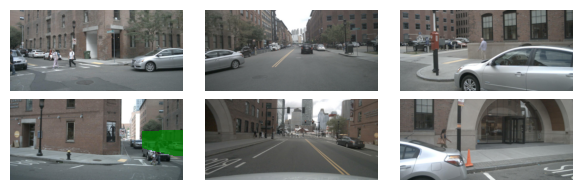

In [3935]:
fig, axes = plt.subplots(2, 3, figsize=(6, 2))

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    image = images[i].permute(1, 2, 0).numpy()
    # if i > 2:
    #     image = np.fliplr(image)
    ax.imshow(image)

axes.flatten()[cam].imshow(np.ma.masked_where(cam_ood == 0, cam_ood), 'ocean', alpha=.75)

print(np.sum(cam_ood))

plt.tight_layout()

(-0.5, 199.5, 199.5, -0.5)

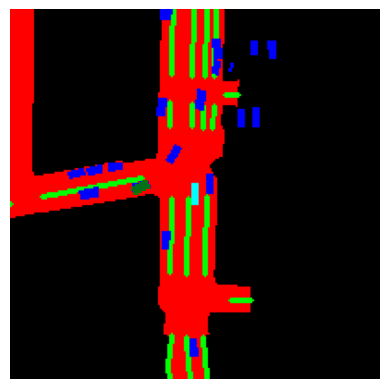

In [3936]:
plt.imshow(map_rgb(labels, ego=True)/255)
plt.imshow(np.ma.masked_where(bev_ood == 0, bev_ood), 'ocean', alpha=.9)
plt.axis("off")

In [3937]:
from scipy.spatial.transform import Rotation as R

# Given initial rotation
r_init = R.from_euler('zyx', [90, 0, 90], degrees=True)

# Desired final rotation
r_desired = R.from_euler('zyx', [0, 0, -180], degrees=True)

# Calculate the additional rotation needed
r_diff = r_desired * r_init.inv()

# Print the Euler angles of the additional rotation
euler_diff = r_diff.as_euler('zyx', degrees=True)
print(euler_diff)

[90.         90.00000085  0.        ]


/tmp/ipykernel_3502749/3516367325.py:13: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  euler_diff = r_diff.as_euler('zyx', degrees=True)
